# Fashion MNIST with Keras using a Multilayer perceptron

**Note**: This tutorial is based off of the [Keras MNIST tutorial](https://github.com/wxs/keras-mnist-tutorial) by [wxs](https://github.com/wxs).

*Fashion MNIST* is a dataset from online fashion retailer *Zalando* consisting of a training set of 60,000 examples and a test set of 10,000 examples, where each example is a 28x28 grayscale image belonging to one of 10 possible classes (such as a t-shirt, dress, etc). It can be used as a drop-in replacement for the original MNIST digit dataset. 

In this tutorial, we'll train a type of **fully connected neural network** called a **multilayer perceptron** to predict the clothing category for each image. Because the image can belong to one of ten categories, this prediction problem is a multi-class classification problem. We will access the neural network library *Keras* through a *Tensorflow* backend.

The class labels are as follows:

| Label | Description   | 
| ----- |:-------------:| 
| 0     | T-shirt/top   | 
| 1     | Trouser       |   
| 2     | Pullover      |  
| 3     | Dress         | 
| 4     | Coat          |   
| 5     | Sandal        | 
| 6     | Shirt         | 
| 7     | Sneaker       |   
| 8     | Bag           |  
| 9     | Ankle boot    |  

# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from keras.callbacks import ModelCheckpoint
from keras.datasets import fashion_mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

//anaconda/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Let's look at some examples of the training data.

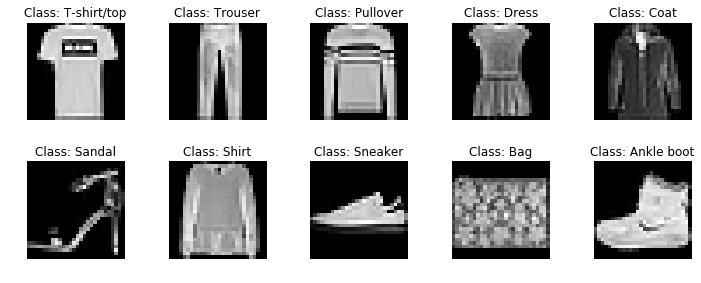

In [4]:
class_labels_dict = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}

fig = plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    img = X_train[y_train == i][0]
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Class: {}".format(class_labels_dict[i]))
    plt.axis('off')
    
plt.tight_layout()

# Format the data

The inputs to our neural network have to be single vectors rather than 2D images. As a result, we will have to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. Unfortunately, this leads to some loss of information, as it becomes less clear which image pixels are next to each other.

In [5]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We also normalise the inputs so that pixel values are in the [0-1] range rather than [0-255].

In [6]:
X_train /= 255
X_test /= 255

At the moment, the target vectors `y_train` and `y_test` are represented as arrays which can take the values 0, 1, 2, etc. This means our model would assume that predicting 1 instead of 0 is better than predicting 5. But our labels are actually categorical - the value 0 encodes t-shirts or tops, which are no more similar to trousers (encoded by 1) than they are to sandals (encoded by 5). To address this, we use **one-hot encoding**, a common technique for dealing with categorical variables.

One-hot encoding maps the classes in the following way:

`
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
`
etc.

In [7]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices using one-hot encoding
num_classes = 10 # There are 10 classes possible 
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# Build the neural network

In this tutorial, we are building a **fully connected** network. This is a general purpose architecture where each node is connected to every node in the previous layer. 

![Neural Network Architecture](http://www.dspguide.com/graphics/F_26_5.gif)
Figure from [The Scientist and Engineer's Guide to Digital Signal Processing](http://www.dspguide.com/ch26/2.htm)

When defining a neural network, we need to decide on the **number of hidden layers**, the **number of nodes in each layer**, and the **activation functions** used between layers. We will build a simple network of three layers - an input layer, one hidden layer, and an output layer, with 512 units in the input and hidden layer. 

**Activation functions** propagate the output of one layer's nodes forward to the next layer. We use the *ReLU* activation function for the input and hidden layer, and the *softmax* activation function for the output layer. The softmax activation function normalizes output and assigns a probability to each class. For instance, if the model see a picture of a dress, it might assign a 80% probability that the item of clothing is a dress, as well as 10% probability that it's a pullover, and smaller probabilities to the other remaining classes. We then predict the class with the highest probability.

We also add **Dropout** masks in between layers. These masks help prevent the model from overfitting on the training data.

In [8]:
model = Sequential() # Declare a Sequential model 
model.add(Dense(512, input_shape=(784,))) # Add a dense input layer of 512 units
                                        # The input shape is (784,) because the features are 784 dimensional vectors
model.add(Activation('relu')) # Apply ReLu activation function to the layer output
model.add(Dropout(0.2)) # Dropout helps prevent the model from overfitting on the training data
model.add(Dense(512)) # Add a hidden layer of 512 units
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes)) # Add an output layer of 10 units, the number of classes 
model.add(Activation('softmax')) # The "softmax" activation ensures the output is a valid probability distribution

# Compile the model

When compiling a model, Keras requires a **loss function** and **optimiser**. 

- The loss function we'll use here is **categorical cross entropy**, a popular loss function well-suited to comparing two probability distributions. It is given by the formula $H(p,q) = -\sum\limits_{x} p(x) \text{log} (q(x))$, where $p$ is the predicted probability and $q$ is the actual probability. We sum over the 10 possible classes. Cross entropy loss increases as the predicted probability diverges from the actual label. Suppose the actual label of an observation is 1 but our predicted probability for class 1 is 0.01. This would give a higher loss value than a predicted probability of 0.40. A perfect model would have a loss value of 0.


- The optimiser determines the **learning rate** of the neural network. The learning rate is the amount by which you adjust parameters to minimise the neural network's errors. A large learning rate means parameters take leaps - this can save time but can overshoot. A small learning rate inches along slowly, but can take longer. Here, we will use the "Adam" optimiser to determine the learning rates for us.

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model

Next, we fit our model on the training set and use it to make predictions on the test set. 

The hyperparameters we pass here are:
- **batch size** - the number of training examples used in one forward/backward pass of the neural network model
- **number of epochs** - the number of times the training algorithm iterates over the *entire* training set

A greater batch size results in a more accurate calculation of the gradient, but comes at the cost of a greater memory requirement and [potentially overfitting](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network). If we have 60k examples in our training dataset, and a batch size of 128 examples, then each epoch will involve 469 iterations. 

Increasing the number of epochs leads to greater accuracy on the training set, but it can also lead to overfitting, demonstrated by an increase in the error rate on the test set.  

We will use Keras' `ModelCheckpoint` to save the model as an HDF5 file for future use. This saved model will include the specified architecture and the weights that the model has learned over the training data. We could then load this model using `load_model`. By specifying `save_best_only` we only save the model at its best-performing epoch.

In [10]:
filepath="mlp-weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(X_train, 
                    Y_train,
                    batch_size=128, 
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test,Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 10s 172us/step - loss: 0.5149 - acc: 0.8133 - val_loss: 0.4130 - val_acc: 0.8515
Epoch 2/25
60000/60000 [==============================] - 10s 163us/step - loss: 0.3799 - acc: 0.8618 - val_loss: 0.3806 - val_acc: 0.8639
Epoch 3/25
60000/60000 [==============================] - 10s 170us/step - loss: 0.3494 - acc: 0.8705 - val_loss: 0.3547 - val_acc: 0.8713
Epoch 4/25
60000/60000 [==============================] - 10s 173us/step - loss: 0.3253 - acc: 0.8799 - val_loss: 0.3602 - val_acc: 0.8686
Epoch 5/25
60000/60000 [==============================] - 10s 170us/step - loss: 0.3107 - acc: 0.8852 - val_loss: 0.3402 - val_acc: 0.8773
Epoch 6/25
60000/60000 [==============================] - 10s 171us/step - loss: 0.2952 - acc: 0.8891 - val_loss: 0.3318 - val_acc: 0.8828
Epoch 7/25
60000/60000 [==============================] - 11s 178us/step - loss: 0.2856 - acc: 0.8931 - val_loss: 0.

# Evaluate Performance

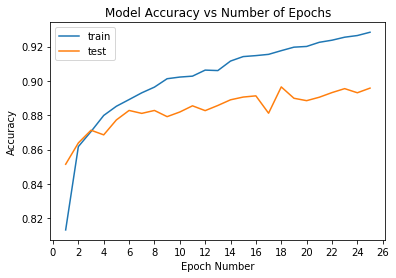

In [11]:
plt.plot(range(1,1+len(history.history['acc'])), history.history['acc'])
plt.plot(range(1,1+len(history.history['val_acc'])), history.history['val_acc'])
plt.title('Model Accuracy vs Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

In [12]:
best_score = max(history.history['val_acc'])
best_epoch = np.array(history.history['val_acc']).argmax()+1
print('Best test accuracy was %f at epoch %i' % (best_score, best_epoch))

Best test accuracy was 0.896500 at epoch 18


We see that, as expected, the accuracy on the training set increases with the number of epochs. The test set accuracy also initially increases with the number of epochs. However, at some point it may actually start to decrease due to overfitting. In fact, we start to see this effect here, where the test set accuracy is actually highest at the 18th epoch rather than the 25th epoch. At the 18th epoch, we achieve our highest **test set accuracy of 89.65%**. 

# Inspecting the output

It's always a good idea to inspect the output. Here we'll look at some examples the model gets right, and some examples it gets wrong.

In [13]:
y_pred = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(y_pred == y_test)[0]
incorrect_indices = np.nonzero(y_pred != y_test)[0]

Let's look at some examples that the neural network predicted correctly.

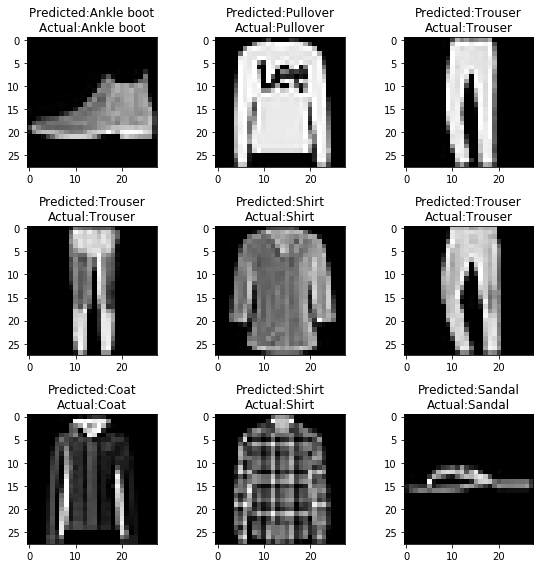

In [14]:
plt.figure(figsize=(8,8))

for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted:{}\nActual:{}".format(class_labels_dict[y_pred[correct]],class_labels_dict[y_test[correct]]))

plt.tight_layout() 

Now let's look at some examples that the neural network predicted incorrectly.

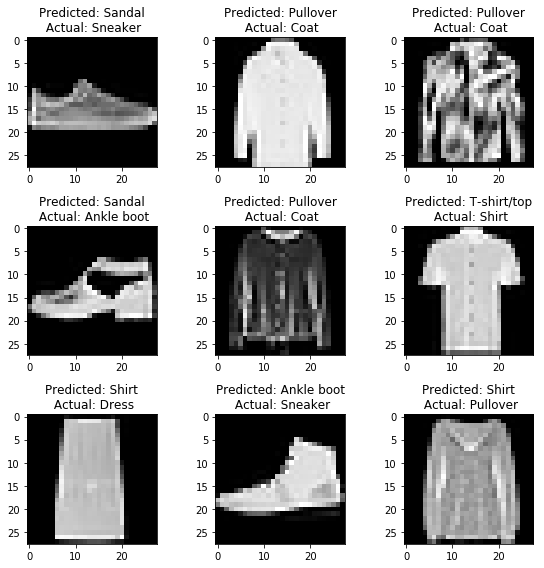

In [15]:
plt.figure(figsize=(8,8))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted: {}\n Actual: {}".format(class_labels_dict[y_pred[incorrect]], class_labels_dict[y_test[incorrect]]))
    
plt.tight_layout() 

Encouragingly, a human observer can understand why many of these items may have been misclassified. For instance, the shoe in the middle row appears to have some of the characteristics of a sandal rather than an ankle boot. Similarly, the shoe in the bottom row looks like it could easily be an ankle boot rather than a sneaker. We also see a few examples where the model has incorrectly predicted a coat to be a pullover. 

Our analysis above also suggests that some classes may get misclassified more frequently than others. We can use the `classification_report` method from `scikit-learn` to get the classification metrics on each class. This will allow us to see which classes are most frequently misclassified. 

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = [class_labels_dict[x] for x in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.88      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.77      0.87      0.81      1000
       Dress       0.90      0.90      0.90      1000
        Coat       0.83      0.79      0.81      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.76      0.67      0.71      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.96      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Five of the ten classes (Trouser, Sandal, Sneaker, Bag, and Ankle boot) achieve an F1-score of 0.96 or higher. Our neural network is more successfully in correctly classifying these classes, suggesting that there are obvious image features that can be used to tell them apart.

On the other hand, the classes with the lowest F1-scores are Shirt (0.71), Coat (0.81) and Pullover (0.81), followed by T-shirt/top (0.85) and Dress (0.90). This may suggest that it is more difficult to 

The classes with the lowest precision are Shirt (0.76) and Pull over (0.77). Low precision suggests that there was a substantial number of items that we classified as pullovers but which aren't actually pullovers. We saw this scenario three times in the examples above, where coats were misclassified as pullovers.

The classes with the lowest recall are Shirt (0.67) and Coat (0.79). Low recall suggests that there was a substantial number of shirts which we didn't identify as shirts, and coats which we didn't identify as coats. Again, we saw examples of this above.  

We can also look at the **confusion matrix** to see how the classes have been misclassified. For instance, we can see that t-shirts/tops were commonly misclassified as shirts, while coats were misclassified as shirts or pullovers. 

In [31]:
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index=target_names, columns=target_names)
matrix.index.name = 'Predicted'
matrix.columns.name = 'Actual'
matrix

Actual,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Predicted,,,,,,,,,,
T-shirt/top,877,0,18,18,2,1,82,0,2,0
Trouser,3,978,2,9,3,0,5,0,0,0
Pullover,18,1,867,9,55,0,50,0,0,0
Dress,21,10,9,903,30,0,24,0,3,0
Coat,1,0,131,29,791,0,47,0,1,0
Sandal,0,0,0,0,0,972,0,15,0,13
Shirt,125,1,102,26,70,0,673,0,3,0
Sneaker,0,0,0,0,0,12,0,959,0,29
Bag,7,0,3,4,3,2,8,4,969,0


# Conclusion and Areas for further investigation

With our general purpose neural network architecture, we have managed to achieve a **test set accuracy of 89.65%**, nearly 90%. While this still isn't good enough for an industrial application, in comparison, a random classifier would achieve 10% accuracy. 

Recall that when we built the neural network, we had to specify the number of hidden layers (also known as the **network depth**), the number of nodes in each layer (the **layer size**), and the activation functions between layers. We also had to pass several hyperparameters when compiling and training the model, including the batch size. Experimenting with these settings could lead to different results. To see how varying the network depth and layer size affects performance, please refer to [this great tutorial on the original MNIST dataset](https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3). 

In this tutorial, we have used the multilayer perceptron architecture. As a result, we had to reshape our images into single vectors which led to some information loss. However, there are many different architectures, for instance **convolutional neural networks** which are particularly well suited for image classification problems.

# Resources
This tutorial was written with the help of the following resources:
- [Building a simple neural-network with Keras](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb) on *Github*
- [Not another MNIST tutorial with TensorFlow](https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow) on *O'Reilly*
- [Train your first neural network: basic classification](https://www.tensorflow.org/tutorials/keras/basic_classification) on *TensorFlow*